<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Результаты-эксперимента" data-toc-modified-id="Результаты-эксперимента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты эксперимента</a></span><ul class="toc-item"><li><span><a href="#A/A-тест-(группы-246-и-247)" data-toc-modified-id="A/A-тест-(группы-246-и-247)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>A/A тест (группы 246 и 247)</a></span></li><li><span><a href="#A/B-тест-(группы-246-и-248)" data-toc-modified-id="A/B-тест-(группы-246-и-248)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>A/B тест (группы 246 и 248)</a></span></li><li><span><a href="#A/B-тест-(группы-247-и-248)" data-toc-modified-id="A/B-тест-(группы-247-и-248)-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>A/B тест (группы 247 и 248)</a></span></li><li><span><a href="#A+A/B-тест-(группы-246+247-и-248)" data-toc-modified-id="A+A/B-тест-(группы-246+247-и-248)-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>A+A/B тест (группы 246+247 и 248)</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Данные" data-toc-modified-id="Данные-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Эксперимент" data-toc-modified-id="Эксперимент-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Эксперимент</a></span></li></ul></li></ul></div>

# Анализ пользовательского поведения в мобильном приложении

Необходимо разобраться, как ведут себя пользователи  мобильного приложения стартапа, который продает продукты питания.

Потребуется изучить воронку продаж и узнать, как пользователи доходят до покупки. Определить сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.

Также нужно исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: *246* и *247* — контрольные группы, а *248* — экспериментальная.

## Предобработка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import math as mth

from plotly import graph_objects as go
from scipy import stats as st

In [2]:
# чтение файла
try: 
    logs = pd.read_csv('logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [4]:
# функция с обзором данных
def first_view(df):
    raw_shape_df = df.shape
    display(df.head(3))
    display(df.info())
    print(f'Размер датасета: {raw_shape_df}')
    print(f'Всего дубликатов: {df.duplicated().sum()}')
    
    cols = []
    nans = []
    pnans = []
    
    if df.isna().sum().sum() == 0:
        print('Пропущенных значений не обнаружено')
    else:
        for i in df.columns:
            if df[i].isna().sum() != 0:
                cols.append(i)
                nans.append(df[i].isna().sum())
                pnans.append(df[i].isna().sum() / df.shape[0] * 100)
                
    if len(cols) != 0:
        print('\n')
        print('Пропущенные значения по столбцам:')
        display(
            pd.DataFrame(
            {
                'column_name': cols, 
                'number_of_na': nans, 
                'percent_of_na': pnans
            }
            ).style.format({'percent_of_na': '{:.2f}%'}).background_gradient()
        )
    return raw_shape_df

In [6]:
# вызываем функцию обзора данных и создаем переменную с размером датасета
raw_shape = first_view(logs)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Размер датасета: (244126, 4)
Всего дубликатов: 413
Пропущенных значений не обнаружено


In [9]:
# переименование столбцов
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [14]:
# запишем изначальную длину датасета и количество уникальных пользователей в переменные
len_logs_raw = raw_shape[0]
unique_users_raw = logs.device_id_hash.nunique()

In [16]:
# создание столбцов даты со временем и даты
logs['date_time'] = pd.to_datetime(logs.event_timestamp, unit='s')
logs['date'] = logs.date_time.dt.date

In [17]:
# удаление дубликатов
logs = logs.drop_duplicates()

In [18]:
# проверим попали ли какие-то пользователи одновременно в группы 246 и 247
len(np.intersect1d(
    logs[logs.exp_id == 246].device_id_hash.unique(),
    logs[logs.exp_id == 247].device_id_hash.unique())
)

0

In [19]:
# проверим попали ли какие-то пользователи одновременно в группы 246 и 248
len(np.intersect1d(
    logs[logs.exp_id == 246].device_id_hash.unique(),
    logs[logs.exp_id == 248].device_id_hash.unique())
)

0

In [20]:
# проверим попали ли какие-то пользователи одновременно в группы 248 и 247
len(np.intersect1d(
    logs[logs.exp_id == 248].device_id_hash.unique(),
    logs[logs.exp_id == 247].device_id_hash.unique())
)

0

In [21]:
# процент удаленных данных
round(
    (1 - logs.shape[0] / len_logs_raw) * 100, 2
)

0.17

In [22]:
# процент удаленных пользователей
round(
    (1 - logs.device_id_hash.nunique() / unique_users_raw) * 100, 2
)

0.0

На данном этапе: 
* изменили названия столбцов для более удобной дальнейшей работы
* проверили на наличие пропусков - данные полные, пропущенных значений не обнаружено
* добавили стобцы `date_time` со значением времени и даты и `date` со значением даты с соответствующими типами данных
* проверили попадание пользователей в разные тестовые группы - таких пользователей не обнаружено
* проверили наличие дубликатов и удалили 413 повторяющихся записей, таким образом удалено `0.17%` данных

## Обзор данных

In [23]:
# общее количество событий
logs.shape[0]

243713

In [24]:
# количество пользователей
logs.device_id_hash.nunique()

7551

In [25]:
# среднее количество действий пользователя
round(
    logs.groupby('device_id_hash')['event_name'].count().mean(),
    2
)

32.28

In [26]:
# максимальная и минимальная даты
display(logs.date_time.max())
logs.date_time.min()

Timestamp('2019-08-07 21:15:17')

Timestamp('2019-07-25 04:43:36')

* Всего имеются данные о `243713` событиях
* Представлены данные действий `7551` пользователя
* В среднем один пользователь совершает `32-33` действия
* Временной интервал событий - c `25 июля 2019 года` до `7 августа 2019 года` 

In [27]:
sns.set_theme(rc={'figure.figsize': (17, 6)}, style='whitegrid')

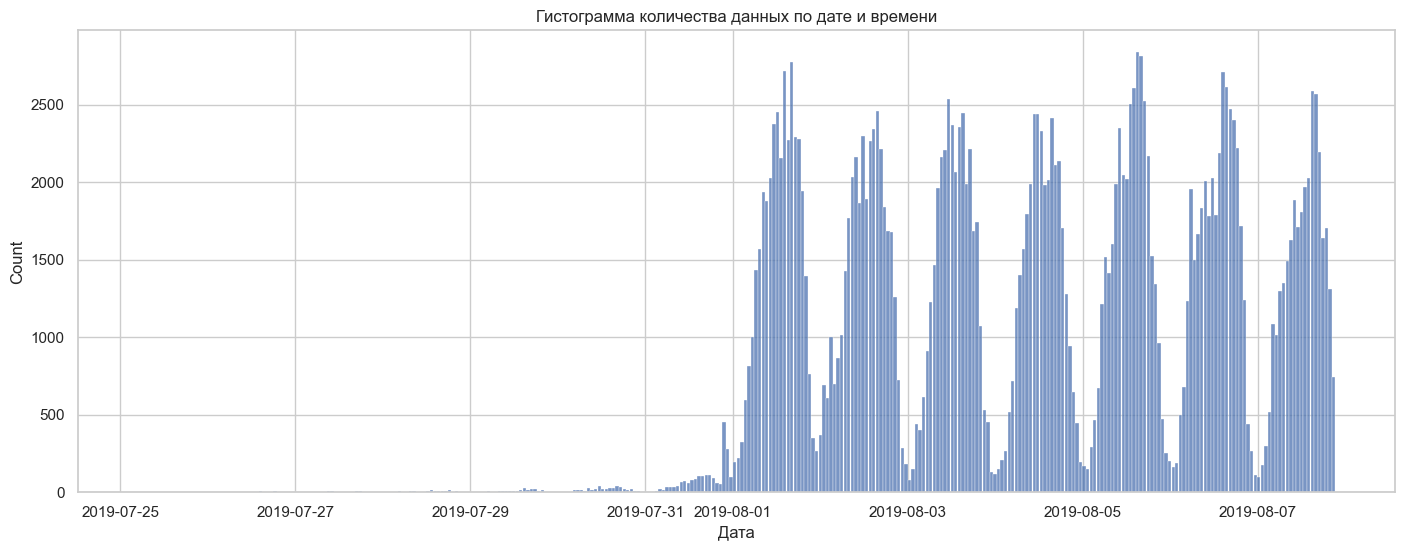

In [28]:
sns.histplot(logs.date_time, bins=14*24, shrink=0.95)
plt.title('Гистограмма количества данных по дате и времени')
plt.xlabel('Дата')
plt.show()

На самом деле мы располагаем полными данными только с `1-го августа 2019 года`. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Поэтому удалим события до `01.08.2019`. Также сразу можно отметить, что в ночные часы совершается меньшее количество действий.

In [29]:
logs = logs[logs.date >= dt.date(2019, 8, 1)]
logs.shape[0]

240887

In [30]:
# процент удаленных данных
round(
    (1 - logs.shape[0] / len_logs_raw) * 100, 2
)

1.33

In [31]:
# количество пользователей после удаления данных
logs.device_id_hash.nunique()

7534

In [32]:
# количество удаленных пользователей
display(unique_users_raw - logs.device_id_hash.nunique())
# процент удаленных пользователей
round(
    (1 - logs.device_id_hash.nunique() / unique_users_raw) * 100, 2
)

17

0.23

Таким образом, удалили `1.33%` записей от изначального количества (после удаления дубликатов и неполных данных за прошлый период). В это число входят данные `17` пользователей (`0.23%` от общего количества пользователей).

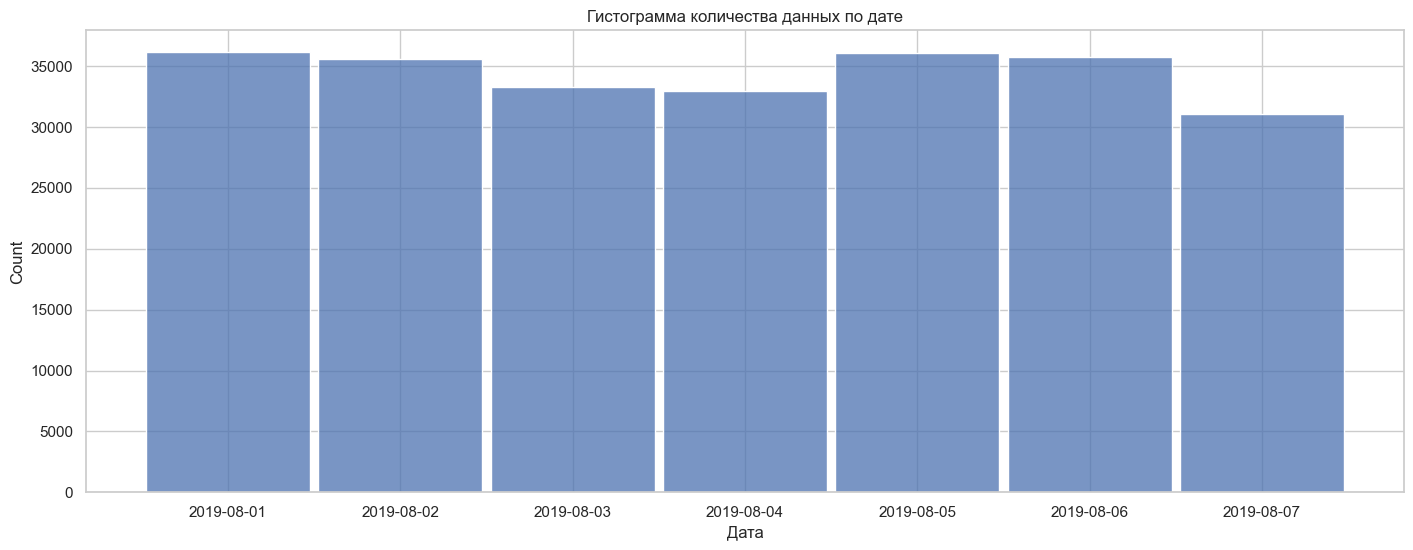

In [33]:
sns.histplot(logs.date, shrink=0.95)
plt.title('Гистограмма количества данных по дате')
plt.xlabel('Дата')
plt.show()

In [34]:
(
    logs
    .pivot_table(index='date', values='event_name', aggfunc='count')
    .reset_index()
    .rename(columns={'event_name': 'events_count'})
    .style.background_gradient()
)

,date,events_count
0,2019-08-01,36141
1,2019-08-02,35554
2,2019-08-03,33282
3,2019-08-04,32968
4,2019-08-05,36058
5,2019-08-06,35788
6,2019-08-07,31096


Получили данные за `7 дней` - c `1 августа 2019` года по `7 августа 2019 года`. В каждый день зафиксировано сопоставимое количество событий.

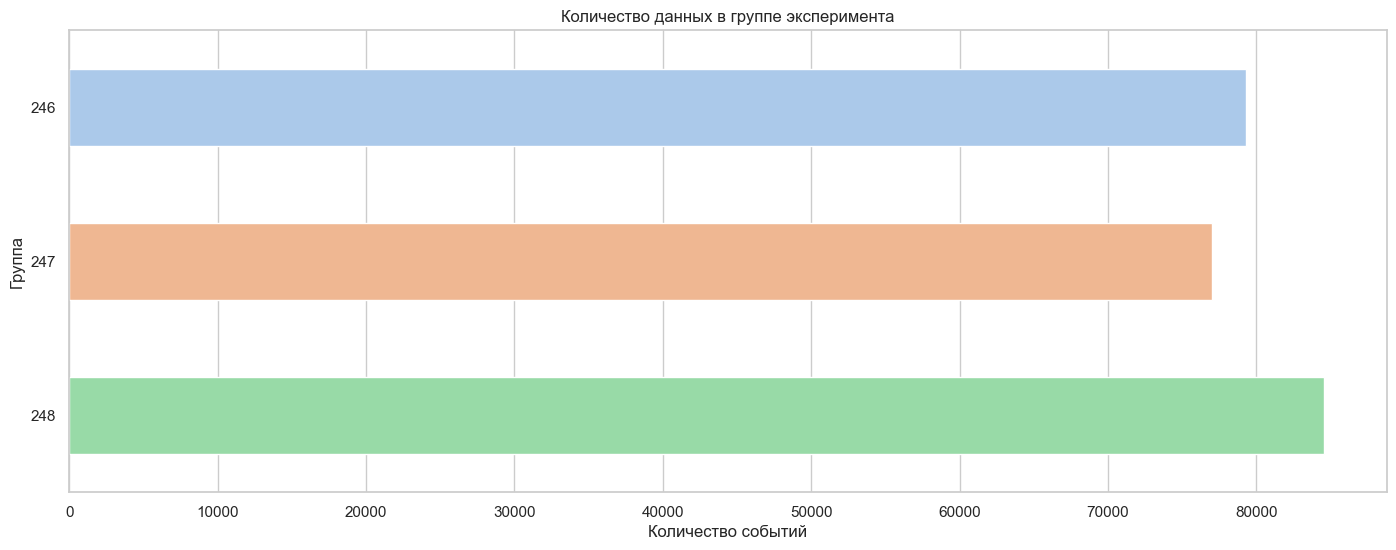

In [35]:
sns.barplot(
    data=logs.pivot_table(index='exp_id', values='event_name', aggfunc='count').reset_index(), 
    y='exp_id', 
    x='event_name',
    palette='pastel',
    width=0.5, 
    orient='h'
)
plt.title('Количество данных в группе эксперимента')
plt.ylabel('Группа')
plt.xlabel('Количество событий')
plt.show()

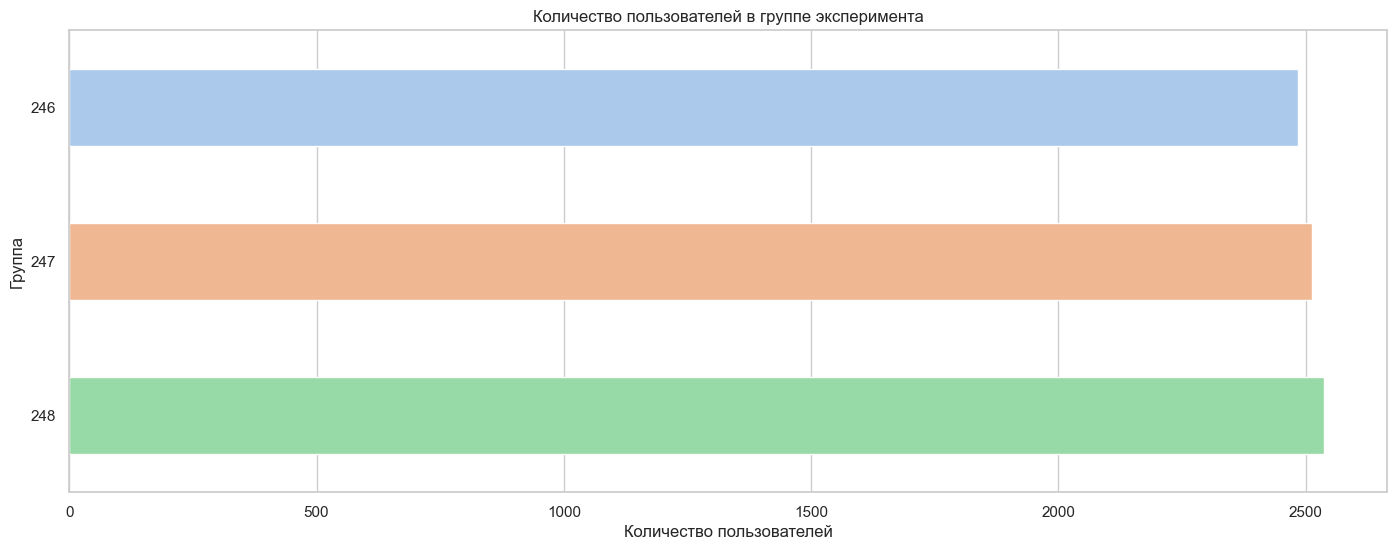

In [36]:
sns.barplot(
    data=logs.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique').reset_index(), 
    y='exp_id', 
    x='device_id_hash',
    palette='pastel',
    width=0.5, 
    orient='h'
)
plt.title('Количество пользователей в группе эксперимента')
plt.ylabel('Группа')
plt.xlabel('Количество пользователей')
plt.show()

In [37]:
groups = (
    logs
    .pivot_table(index='exp_id', values='device_id_hash', aggfunc=['count', 'nunique'])
    .reset_index()
    .rename(columns={'count': 'events_count', 'nunique': 'users_count'})
)
groups.columns = groups.columns.droplevel(1)
groups.style.background_gradient()

,exp_id,events_count,users_count
0,246,79302,2484
1,247,77022,2513
2,248,84563,2537


В каждой группе достаточное количество событий и пользователей, чтобы можно было проводить дальнейший анализ.

Таким образом в нашем распоряжении имеется `240887` записей о действиях `7534` пользователей с `1 по 7 августа  2019 года`. Все пользователи и их действия разделены на три группы:
* группа **246** (`A`) - `79302` события `2484` пользователей
* группа **247** (`A`) - `77022` события `2513` пользователей
* группа **248** (`B`) - `84563` события `2537` пользователей

## Воронка событий

In [38]:
# количество уникальных типов событий
logs.event_name.nunique()

5

In [39]:
logs.event_name.unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

Всего есть 5 типов событий:
* `MainScreenAppear` - показ главной страницы
* `PaymentScreenSuccessful` - страница с успешной оплатой
* `CartScreenAppear` - показ корзины
* `OffersScreenAppear` - показ страницы с предложениями
* `Tutorial` - руководство

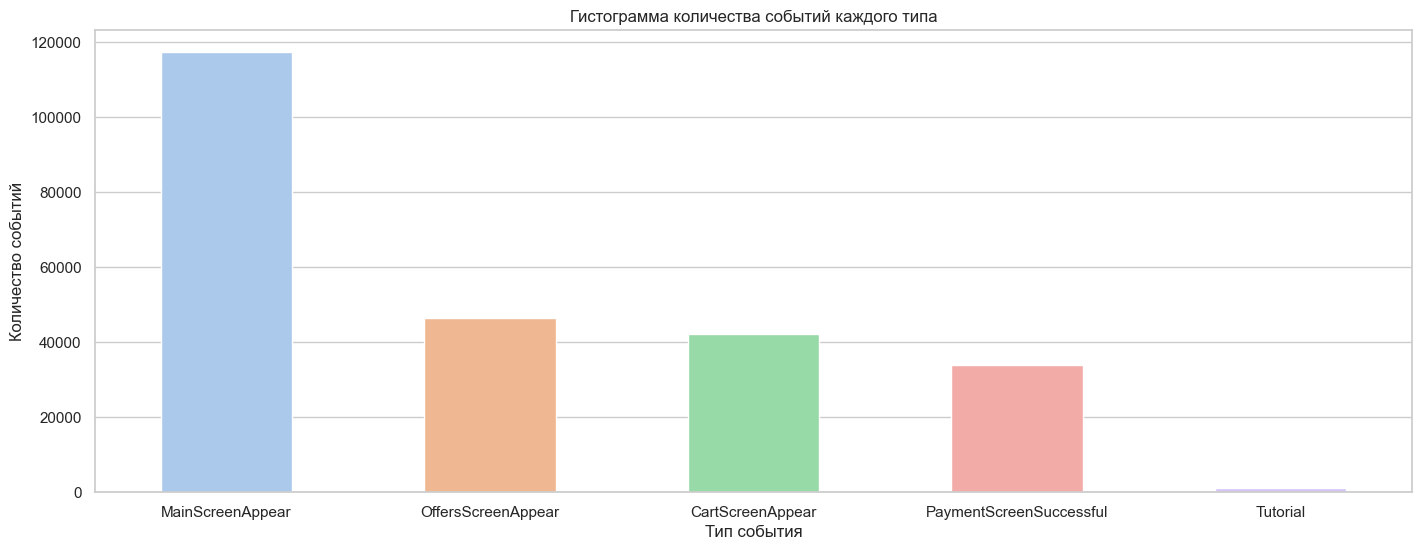

In [40]:
sns.barplot(
    data=logs.pivot_table(
        index='event_name', 
        values='event_timestamp', 
        aggfunc='count'
    ).reset_index().sort_values('event_timestamp', ascending=False), 
    y='event_timestamp', 
    x='event_name',
    palette='pastel',
    width=0.5
)
plt.title('Гистограмма количества событий каждого типа')
plt.xlabel('Тип события')
plt.ylabel('Количество событий')
plt.show()

In [41]:
events_count = (
    logs
    .pivot_table(index='event_name', values='event_timestamp', aggfunc='count')
    .reset_index()
    .rename(columns={'event_timestamp': 'events_count'})
    .sort_values('events_count', ascending=False)
)
events_count['percent_of_all_events'] = round(events_count.events_count / logs.shape[0] * 100, 2)
events_count

,event_name,events_count,percent_of_all_events
1,MainScreenAppear,117328,48.71
2,OffersScreenAppear,46333,19.23
0,CartScreenAppear,42303,17.56
3,PaymentScreenSuccessful,33918,14.08
4,Tutorial,1005,0.42


Имеем `5` типов событий. Можно предположить, что именно так и строится наша воронка событий для пользователя: показ главной страницы, далее страница с предложениями, страница корзины и сообщение об успешной оплате. А страницу с руководством посещают редко (всего `0.42%` от всех событий) и ее посещение не влияет на данную воронку, также посещение руководства может происходить в любой момент, поэтому удалим эти события.

In [42]:
logs = logs[logs.event_name != 'Tutorial']

In [43]:
# процент оставшихся данных
round(
    (logs.shape[0] / len_logs_raw) * 100, 2
)

98.26

In [44]:
# количество удаленных пользователей
display(unique_users_raw - logs.device_id_hash.nunique())
# процент оставшихся пользователей
round(
    (logs.device_id_hash.nunique() / unique_users_raw) * 100, 2
)

21

99.72

После удаления записей о посещении страницы руководства осталось `98.26%` от изначальных данных (`99.72%` всех пользователей).

In [45]:
users_count = (
    logs
    .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
    .rename(columns={'device_id_hash': 'users_count'})
    .sort_values('users_count', ascending=False)
    .reset_index()
)
users_count['percent_of_all_users'] = round(users_count.users_count / logs.device_id_hash.nunique() * 100, 2)
for i in users_count.index:
    if i == 0:
        users_count.loc[i, 'percent_by_steps'] = 100.0
    else:
        users_count.loc[i, 'percent_by_steps'] = round(
            users_count.loc[i, 'users_count'] / users_count.loc[i - 1, 'users_count'] * 100, 2
        )
users_count

,event_name,users_count,percent_of_all_users,percent_by_steps
0,MainScreenAppear,7419,98.53,100.00
1,OffersScreenAppear,4593,61.00,61.91
2,CartScreenAppear,3734,49.59,81.30
3,PaymentScreenSuccessful,3539,47.00,94.78


Почти все пользователи посещают главную страницу (98.53%). Поэтому мы можем построить воронку, приняв посещение главной страницы за 100%.

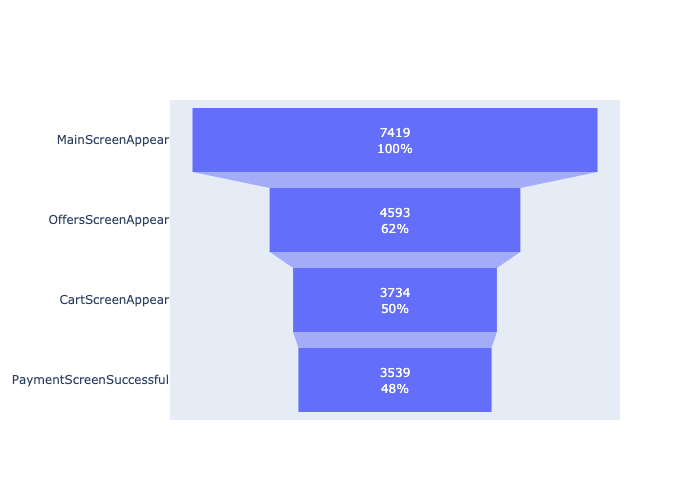

In [46]:
fig = go.Figure(
    go.Funnel(
        y = users_count.event_name, 
        x = users_count.users_count, 
        textinfo = 'value+percent initial'
    )
)

fig.show('png')

Таким образом, при прохождении воронки на каждом этапе теряются пользователи. Наибольшие потери при переходе от главной страницы к странице с предложениями. Только `62%` пользователей доходят до этого этапа. На следующих этапах потери не такие большие: `81%` пользователей, посетивших страницу с предложениями переходит в корзину, и `95%` пользователей совершают оплату, если они уже были на странице корзины. Всего до оплаты доходит `47%` от изначального количества пользователей.

## Результаты эксперимента

In [47]:
# т.к. удалили записи о посещении руководства, 
# выведем еще раз таблицу с количеством событий и пользователей по группам
groups = (
    logs
    .pivot_table(index='exp_id', values='device_id_hash', aggfunc=['count', 'nunique'])
    .reset_index()
    .rename(columns={'count': 'events_count', 'nunique': 'users_count'})
)
groups.columns = groups.columns.droplevel(1)
groups.style.background_gradient()

,exp_id,events_count,users_count
0,246,78985,2483
1,247,76684,2512
2,248,84213,2535


Необходимо сравнивать доли клиентов в каждом событии в каждой группе.

Согласно центральной предельной теореме выборочные доли будут нормально распределены вокруг настоящей. Поэтому для проверки гипотез мы можем воспользоваться Z-тестом со стандартным нормальным распределением: со средним, равным нулю, и стандартным отклонением, равным единице.
$$ Z \approx \frac{(P_1 - P_2) - (\pi_1 - \pi_2)}{\sqrt{P(1-P)(1/n_1 + 1/n_2)}} \sim N(0, 1) $$
* $n_1$ и $n_2$ - размеры двух сравниваемых выборок, то есть количества наблюдений в них, в нашем случае это будут количества пользователей в группах
* $P_1$ и $P_2$ - пропорции, наблюдаемые в выборках - отношения количества пользователей в событии к общим количествам пользователей по группам
* $P$ - пропорция в выборке, скомбинированной из двух наблюдаемых - отношение общего количества пользователей в событии в обеих группах к общему количеству пользователей обеих групп
* $\pi_1$ и $\pi_2$ - настоящие пропорции в сравниваемых генеральных совокупностях

Будем проверять гипотезу о равенстве $\pi_1$ и $\pi_2$. Тогда при верной нулевой гипотезе выражение $(\pi_1 - \pi_2)$ в числителе будет равно нулю, и критерий можно рассчитывать только по выборочным данным.

Будем проводить двусторонние тесты для проверки равенства пропорций двух генеральных совокупностей.

In [48]:
# зададим функцию для проверки гипотезы о равенстве долей
def z_test(successes, trials, alpha):

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # p-value для двустороннего теста
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Т.к. будем проводить множественный тест для проверки равенства долей, то введем поправку Бонферрони для уровня значимости. Будем сравнивать доли в группах $A_1/A_2$, $A_1/B$, $A_2/B$, $(A_1 + A_2)/B$, в каждой группе по 4 теста - проверка равенства долей клиентов на главной странице, проверка равенства долей клиентов на странице предложений, проверка равенства долей клиентов в корзине, проверка равенства долей клиентов с оплатой. Таким образом, имеем 4 теста для 4-х вариантов групповых сравнений, т.е. всего будет 16 тестов. Тогда уровень значимости $\alpha$ будет с учетом поправки Бонферрони будет равен $\alpha = \alpha/m$, где $\alpha = 0.05$, $m = 16$.

In [49]:
alpha_bonferroni = 0.05 / 16

### A/A тест (группы 246 и 247)

У нас есть 2 контрольные группы для А/А-эксперимента (**246** и **247**). Чтобы проверить корректность всех механизмов и расчётов, необходимо проверить, находят ли статистические критерии разницу между данными выборками. Будем проверять доли клиентов на каждом из этапов.

**Нулевая гипотеза**: доли клиентов на главной странице одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на главной странице в группах неравны.

In [50]:
# общее количество пользователей в группах
unique_users = np.array([
    logs[logs.exp_id == 246].device_id_hash.nunique(),
    logs[logs.exp_id == 247].device_id_hash.nunique()
])

In [51]:
# количество пользователей на главной странице по группам
users_on_main_screen = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 247) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique()
])

In [52]:
z_test(users_on_main_screen, unique_users, alpha_bonferroni)

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице предложений одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице предложений в группах неравны.

In [53]:
# количество пользователей на странице предложений по группам
users_on_offers_screen = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 247) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique()
])

In [54]:
z_test(users_on_offers_screen, unique_users, alpha_bonferroni)

p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице корзины одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице корзины в группах неравны.

In [55]:
# количество пользователей на странице корзины по группам
users_on_cart_screen = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 247) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique()
])

In [56]:
z_test(users_on_cart_screen, unique_users, alpha_bonferroni)

p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов с оплатой одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов с оплатой в группах неравны.

In [57]:
# количество пользователей с оплатой по группам
users_with_payment = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique(),
    logs[(logs.exp_id == 247) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique()
])

In [58]:
z_test(users_with_payment, unique_users, alpha_bonferroni)

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Таким образом, все тесты показали, что нет оснований отвергать нулевую гипотезу, т.е. нет статистически значимых различий в долях клиентов на каждом этапе воронки в обеих группах A (246 и 247).

### A/B тест (группы 246 и 248)

Будем проверять доли клиентов на каждом из этапов для групп А/B-эксперимента (**246** и **248**).

**Нулевая гипотеза**: доли клиентов на главной странице одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на главной странице в группах неравны.

In [59]:
# общее количество пользователей в группах
unique_users = np.array([
    logs[logs.exp_id == 246].device_id_hash.nunique(),
    logs[logs.exp_id == 248].device_id_hash.nunique()
])

In [60]:
# количество пользователей на главной странице по группам
users_on_main_screen = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique()
])

In [61]:
z_test(users_on_main_screen, unique_users, alpha_bonferroni)

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице предложений одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице предложений в группах неравны.

In [62]:
# количество пользователей на странице предложений по группам
users_on_offers_screen = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique()
])

In [63]:
z_test(users_on_offers_screen, unique_users, alpha_bonferroni)

p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице корзины одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице корзины в группах неравны.

In [64]:
# количество пользователей на странице корзины по группам
users_on_cart_screen = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique()
])

In [65]:
z_test(users_on_cart_screen, unique_users, alpha_bonferroni)

p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов с оплатой одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов с оплатой в группах неравны.

In [66]:
# количество пользователей с оплатой по группам
users_with_payment = np.array([
    logs[(logs.exp_id == 246) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique()
])

In [67]:
z_test(users_with_payment, unique_users, alpha_bonferroni)

p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При A/B тестировании все тесты показали, что статистически значимых различий между долями пользователей на каждом этапе в группах нет. Это говорит о том, что изменение шрифтов не влияет на поведение пользователей. Но проведем еще тесты между второй группой А и B и объединенной группой A+A и B.

### A/B тест (группы 247 и 248)

Будем проверять доли клиентов на каждом из этапов для групп А/B-эксперимента (**247** и **248**).

**Нулевая гипотеза**: доли клиентов на главной странице одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на главной странице в группах неравны.

In [68]:
# общее количество пользователей в группах
unique_users = np.array([
    logs[logs.exp_id == 247].device_id_hash.nunique(),
    logs[logs.exp_id == 248].device_id_hash.nunique()
])

In [69]:
# количество пользователей на главной странице по группам
users_on_main_screen = np.array([
    logs[(logs.exp_id == 247) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique()
])

In [70]:
z_test(users_on_main_screen, unique_users, alpha_bonferroni)

p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице предложений одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице предложений в группах неравны.

In [71]:
# количество пользователей на странице предложений по группам
users_on_offers_screen = np.array([
    logs[(logs.exp_id == 247) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique()
])

In [72]:
z_test(users_on_offers_screen, unique_users, alpha_bonferroni)

p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице корзины одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице корзины в группах неравны.

In [73]:
# количество пользователей на странице корзины по группам
users_on_cart_screen = np.array([
    logs[(logs.exp_id == 247) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique()
])

In [74]:
z_test(users_on_cart_screen, unique_users, alpha_bonferroni)

p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов с оплатой одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов с оплатой в группах неравны.

In [75]:
# количество пользователей с оплатой по группам
users_with_payment = np.array([
    logs[(logs.exp_id == 247) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique()
])

In [76]:
z_test(users_with_payment, unique_users, alpha_bonferroni)

p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При A/B тестировании со второй группой А все тесты также показали, что статистически значимых различий между долями пользователей на каждом этапе в этих группах нет.

### A+A/B тест (группы 246+247 и 248)

Теперь соединим две группы А (246 и 247) и проведем A/B эксперимент для сравнения долей клиентов на каждом из этапов воронки.

**Нулевая гипотеза**: доли клиентов на главной странице одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на главной странице в группах неравны.

In [77]:
# общее количество пользователей в группах
unique_users = np.array([
    logs[(logs.exp_id == 246) | (logs.exp_id == 247)].device_id_hash.nunique(),
    logs[logs.exp_id == 248].device_id_hash.nunique()
])

In [78]:
# количество пользователей на главной странице по группам
users_on_main_screen = np.array([
    logs[((logs.exp_id == 246) | (logs.exp_id == 247)) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'MainScreenAppear')].device_id_hash.nunique()
])

In [79]:
z_test(users_on_main_screen, unique_users, alpha_bonferroni)

p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице предложений одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице предложений в группах неравны.

In [80]:
# количество пользователей на странице предложений по группам
users_on_offers_screen = np.array([
    logs[((logs.exp_id == 246) | (logs.exp_id == 247)) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'OffersScreenAppear')].device_id_hash.nunique()
])

In [81]:
z_test(users_on_offers_screen, unique_users, alpha_bonferroni)

p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов на странице корзины одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов на странице корзины в группах неравны.

In [82]:
# количество пользователей на странице корзины по группам
users_on_cart_screen = np.array([
    logs[((logs.exp_id == 246) | (logs.exp_id == 247)) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'CartScreenAppear')].device_id_hash.nunique()
])

In [83]:
z_test(users_on_cart_screen, unique_users, alpha_bonferroni)

p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая гипотеза**: доли клиентов с оплатой одинаковы в обеих группах.

**Альтернативная гипотеза**: доли клиентов с оплатой в группах неравны.

In [84]:
# количество пользователей с оплатой по группам
users_with_payment = np.array([
    logs[((logs.exp_id == 246) | (logs.exp_id == 247)) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique(),
    logs[(logs.exp_id == 248) & (logs.event_name == 'PaymentScreenSuccessful')].device_id_hash.nunique()
])

In [85]:
z_test(users_with_payment, unique_users, alpha_bonferroni)

p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнивании долей пользователей на каждом этапе воронки между объединенными группами А и группой B, также все тесты показали, что нет статистически значимых различий между этими долями.

Мы проводили все тесты с учетом поправки Бонферрони на множественные сравнения. Если бы мы применили более высокое значение уровня статистической значимости в 0.1, то получили бы один ложный результат (при сравнении доли клиентов на странице предложений между группами 246 и 248, p-value = 0.08), однако все остальные полученные значения удовлетворяют даже этому условию.

## Выводы

### Данные

* В представленных данных нет пропущенных значений
* Не обнаружено пользователей, попавших в разные тестовые группы
* Полные данные представленны за период c `1 августа 2019 года` по `7 августа 2019 года`, данные за другой период удалены
* После предобработки удалено `413` повторяющихся записей (`0.17%` всех данных)
* Сведения, о посещении пользователями руководства (`Tutorial`) не влияют на прохождение воронки, поэтому эти данные также удалены (`0.42%` всех событий)
* Каждый пользователь в среднем совершает более `32` действий

Всего оставлено `98.26%` записей, что также соответствует `99.72%` всех пользователей.
В наличии три тестовые группы пользователей:
* группа **246** (`A`) - `78985` события `2483` пользователей
* группа **247** (`A`) - `76684` события `2512` пользователей
* группа **248** (`B`) - `84213` события `2535` пользователей

### Воронка событий

Воронка событий определена в такой последовательности:
1. посещение пользователем главной страницы `MainScreenAppear`
2. посещение пользователем страницы с предложениями `OffersScreenAppear`
3. посещение пользователем корзины `CartScreenAppear`
4. совершение пользователем оплаты `PaymentScreenSuccessful`

Почти все пользователи посещают главную страницу (`98.53%`). Больше всего пользователей теряется при переходе от главной страницы к странице с предложениями - только `61%` пользователей попадает на страницу с предложениями. В корзине оказывается `50%` пользователей, а оплату совершают `47%` пользователей. Потери при переходе со страницы предложений в корзину и из корзины к оплате невелики - менее `19%` и `5%` соответственно.

### Эксперимент

Проанализировали результаты A/A/B-эксперимента. В двух группах А находились пользователи, у которых оставались прежние шрифты в приложении. В групее B находились пользователи, у которых приложение было с новыми шрифтами. Проводили множественные сравнения для проверки гипотез о равенстве долей пользователей на каждом из этапов воронки между группами (между группой А и второй группой A, между первой группой A и B, между второй группой A и B, между объединенной группой из двух групп A и группой B). Проводили Z-тест с уровнем статистической значимости 0.05 и применением поправки Бонферрони на множественный тест.
* A/A тесты показали, что нет статистически значимых оснований считать, что доли пользователей на этапах воронки в группах различаются. Таким образом, можно говорить, что данные были собраны корректно.
* A/B тесты с каждой из групп A и также с объединенной группой из двух групп A показали, что нет статистически значимых оснований считать, что доли пользователей на каждом из этапов воронки в каждой из групп отличаются.

Таким образом, можно сделать вывод, что **изменение шрифтов в приложении не повлияло на поведение пользователей**, можно производить смену шрифтов, не опасаясь, что пользователям будет непривычно. Однако и к увеличению продаж смена шрифта не приводит.